In [69]:
ticker='LMT'

# Initial Setup

In [70]:
# !pip install yfinance
!pip install simfin
!pip install "notebook>=5.3" "ipywidgets>=7.5"
!pip install yfinance==0.1.62

In [71]:
import yfinance
print(yfinance.__version__)

0.1.62


In [72]:
import pandas as pd
import numpy as np
import math
import pandas_datareader as web
from numbers import Number
import yfinance as yf
import datetime as dt
import requests
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
from itertools import product
import io
plt.figure(figsize=(20,10))
pd.set_option('display.max_columns', None)
pd.set_option('precision', 2)

def Format_Table(final_table):
  pd.options.display.float_format = '{:,}'.format
  i= final_table.copy()
  i.style.format("{:,.0f}")
  i = i.round(decimals=4)
  return i

<Figure size 1440x720 with 0 Axes>

# Data gathering

In [73]:

def yahoo_data_parser(ticker, start, end):

    
    data = pd.DataFrame()
    # data = web.get_data_yahoo(ticker).dropna()
    start_year = start[0]
    start_month = start[1]
    start_day = start[2]
    
    end_year = end[0]
    end_month = end[1]
    end_day = end[2]

    import time
    period1 = int(time.mktime(dt.datetime(start_year, start_month, start_day).timetuple()))
    period2 = int(time.mktime(dt.datetime(end_year, end_month, end_day).timetuple()))
    interval = '1d' # 1d, 1m
    query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'
    data = pd.read_csv(query_string).dropna()

    data['Close'] = data['Adj Close']
    data.drop(['Adj Close'], axis=1)

    #Calculates the log returns of the stock (i.e., the benchmark investment).
    data['Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)

    #Calculates the annualized volatility for the strategy and the benchmark investment.
    data['Volatility'] = data['Returns'].rolling(252).std() * 252 ** 0.5


#     data['Date'] = data['Date'].astype(str)


    data['Date'] = pd.to_datetime(data['Date'], format="%Y/%m/%d", errors='coerce')


    data['Month'] = data['Date'].dt.month
    data['Year'] = data['Date'].dt.year
#     data['Date'] = data.index
    data['Avg_month_price'] = data.groupby([(data.Year),(data.Month)])['Adj Close'].transform('mean')
    data['Avg_month_volatility'] = data.groupby([(data.Year),(data.Month)])['Volatility'].transform('mean')
    return data

In [74]:
start_date = [2017, 12, 31]
end_date = [2021, 12, 31]

data = yahoo_data_parser(ticker, start_date, end_date)
data= Format_Table(data)

data_prices = pd.DataFrame()
data_prices['Year'] = data['Year']
data_prices['Month'] = data['Month']
data_prices['Avg_month_price'] = data['Avg_month_price']
data_prices.reset_index(drop=True, inplace=True)
data_prices = data_prices.drop_duplicates()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Returns,Volatility,Month,Year,Avg_month_price,Avg_month_volatility
1,2018-01-03,318.98,321.52,318.63,286.918,286.918,893400,0.0083,nan,1,2018,298.7512,nan
2,2018-01-04,321.19,326.9,320.99,291.8398,291.8398,1443000,0.017,nan,1,2018,298.7512,nan
3,2018-01-05,325.99,330.18,325.98,294.4837,294.4837,1241100,0.009,nan,1,2018,298.7512,nan
4,2018-01-08,328.96,330.41,327.81,293.126,293.126,1084500,-0.0046,nan,1,2018,298.7512,nan
5,2018-01-09,329.0,331.83,328.42,295.2251,295.2251,865400,0.0071,nan,1,2018,298.7512,nan


In [75]:
company = yf.Ticker(ticker)

cashflow_statement = pd.DataFrame()
cashflow_statement = company.cashflow

financials = pd.DataFrame()
financials = company.financials


balance_sheet = pd.DataFrame()
balance_sheet = company.balance_sheet

df = pd.DataFrame(list(company.info.items()),columns = ['Key','Value']) 

#we need these dataframes transposed, so we have a single row by each time period
#Except for earnings, which comes already transposed and with years instead of YYYMMMDDD.
balance_sheet = balance_sheet.transpose()
financials = financials.transpose()
cashflow_statement = cashflow_statement.transpose()

earnings = pd.DataFrame()
earnings = company.earnings

In [76]:
#Normalize dates columns so we can make a big join later
financials['Date'] = financials.index
cashflow_statement['Date'] = cashflow_statement.index
earnings.index.names = ['Date']
earnings['Year'] = earnings.index
balance_sheet['Date'] = balance_sheet.index

In [77]:
#Net Income gets dupped on financials, so we dropped to avoid having a "Net Income_y" table
financials.drop('Net Income', inplace=True, axis=1)
financials.drop('Minority Interest', inplace=True, axis=1)
result = pd.merge(cashflow_statement, financials, on='Date')
result = pd.merge(result, balance_sheet, on='Date')


#Normalize datetime to years so we can add income table
result['Year']= pd.DatetimeIndex(result['Date']).year
result['Month']= pd.DatetimeIndex(result['Date']).month
result = pd.merge(result, earnings, on='Year')
col_name = 'Date'
first_col = result.pop(col_name)
result.insert(0, col_name, first_col)
result['Working Capital']= result['Total Current Assets']- result['Total Current Liabilities']

In [78]:
pd.set_option('float_format', '{:f}'.format)

## Get Shares

In [79]:
def Get_Shares():

  simfin_api_key = 'En45n7bGFsBZoqGypg0bWJ0C9xGDG7u9'
  request_url = 'https://simfin.com/api/v2/companies/shares'
  
  response = requests.get(request_url, {"ticker": 'ticker', "type": "common", "api-key": simfin_api_key}).json()


  type(response)
  response_dict = response[0]
  type(response_dict)
  last_date_response_dict = response_dict.get('data')
  
  for i in last_date_response_dict:
    i.pop(0)
    i.pop(0)
  
  shares_df = pd.DataFrame(last_date_response_dict, columns = ['Date', 'Shares']) 

  shares_df['Year']= pd.DatetimeIndex(shares_df['Date']).year
  
  return shares_df

shares_simfin = Get_Shares()

In [80]:
if shares_simfin.empty:
  # print('SIMFIN shares returned Empty')
  # shares = pd.DataFrame()
  shares_year_avg = pd.DataFrame()
  shares_year_avg['Year'] = result['Year'].copy()
  yshares= float(company.info.get('sharesOutstanding'))
  shares_year_avg['Shares'] = yshares
  # print(shares_year_avg)
else:  
  shares['Date'] = pd.to_datetime(shares_simfin['Date'])
  shares_year_avg = pd.DataFrame()
  shares_year_avg['Year'] = shares_simfin['Year']
  shares_year_avg['Shares'] = shares_simfin['Shares']
  shares_year_avg['Shares'] = shares_simfin.groupby(shares_simfin['Date'].dt.year)['Shares'].transform('mean')
  shares_year_avg = shares_year_avg.drop_duplicates()


#Use this line only if shares count is wrong
# shares_year_avg['Shares'] = 340000000

In [81]:
result = pd.merge(result, shares_year_avg ,on='Year',how='left')
statements_target_month = result['Month'].iloc[0].astype(int)
statements_target_year = result['Year'].iloc[0].astype(int)

avg_statement_month_prices = data_prices.copy()

if statements_target_year > avg_statement_month_prices['Year'].iloc[-1]:
  print('Statement Year is bigger than avg price year')
  print(avg_statement_month_prices['Year'].iloc[-1])
avg_statement_month_prices = avg_statement_month_prices.drop(avg_statement_month_prices[avg_statement_month_prices.Month != statements_target_month].index)
avg_statement_month_prices = avg_statement_month_prices.drop(['Month'], axis=1)
# print(avg_statement_month_prices)
result = pd.merge(result, avg_statement_month_prices ,on='Year',how='left')
result = Format_Table(result)

In [82]:
initial_fields = ['Date',
                  'Change To Liabilities',
                  'Total Cashflows From Investing Activities',
                  'Net Borrowings',
                  'Total Cash From Financing Activities',
                  'Change To Operating Activities',
                  'Net Income',
                  'Change In Cash',
                  'Repurchase Of Stock',
                  'Total Cash From Operating Activities',
                  'Depreciation',
                  'Other Cashflows From Investing Activities',
                  'Dividends Paid',
                  'Change To Inventory',
                  'Change To Account Receivables',
                  'Other Cashflows From Financing Activities',
                  'Change To Netincome',
                  'Capital Expenditures',
                  'Research Development',
                  'Effect Of Accounting Charges',
                  'Income Before Tax',
                  'Selling General Administrative',
                  'Gross Profit',
                  'Ebit',
                  'Operating Income',
                  'Other Operating Expenses',
                  'Interest Expense',
                  'Extraordinary Items',
                  'Non Recurring',
                  'Other Items',
                  'Income Tax Expense',
                  'Total Revenue',
                  'Total Operating Expenses',
                  'Cost Of Revenue',
                  'Total Other Income Expense Net',
                  'Discontinued Operations',
                  'Net Income From Continuing Ops',
                  'Net Income Applicable To Common Shares',
                  'Intangible Assets',
                  'Capital Surplus',
                  'Total Liab',
                  'Total Stockholder Equity',
                  'Minority Interest',
                  'Other Current Liab',
                  'Total Assets',
                  'Common Stock',
                  'Other Current Assets',
                  'Retained Earnings',
                  'Other Liab',
                  'Good Will',
                  'Treasury Stock',
                  'Other Assets',
                  'Cash',
                  'Total Current Liabilities',
                  'Deferred Long Term Asset Charges',
                  'Short Long Term Debt',
                  'Other Stockholder Equity',
                  'Property Plant Equipment',
                  'Total Current Assets',
                  'Long Term Investments',
                  'Net Tangible Assets',
                  'Net Receivables',
                  'Long Term Debt',
                  'Inventory',
                  'Accounts Payable',
                  'Year',
                  'Month',
                  'Revenue',
                  'Earnings',
                  'Working Capital',
                  'Shares',
                  'Avg_month_price']

current_fields = []
for i in result.columns:
  current_fields.append(i)
for i in initial_fields:
  if i not in current_fields:
    # print(i, "Not here. Setting it up to zero")
    result[i] = 0

# First layer data output

In [83]:
import plotly.graph_objects as go
import plotly.express as px
# data['Close'].plot(figsize=(10, 6))

fig = px.line(data['Close'])
fig.show()
result

,Date,Capital Expenditures,Change In Cash,Change To Account Receivables,Change To Inventory,Change To Liabilities,Change To Netincome,Change To Operating Activities,Depreciation,Dividends Paid,Net Borrowings,Net Income,Other Cashflows From Financing Activities,Other Cashflows From Investing Activities,Repurchase Of Stock,Total Cash From Financing Activities,Total Cash From Operating Activities,Total Cashflows From Investing Activities,Cost Of Revenue,Discontinued Operations,Ebit,Effect Of Accounting Charges,Extraordinary Items,Gross Profit,Income Before Tax,Income Tax Expense,Interest Expense,Net Income Applicable To Common Shares,Net Income From Continuing Ops,Non Recurring,Operating Income,Other Items,Other Operating Expenses,Research Development,Selling General Administrative,Total Operating Expenses,Total Other Income Expense Net,Total Revenue,Accounts Payable,Capital Surplus,Cash,Common Stock,Deferred Long Term Asset Charges,Good Will,Intangible Assets,Inventory,Long Term Debt,Long Term Investments,Minority Interest,Net Receivables,Net Tangible Assets,Other Assets,Other Current Assets,Other Current Liab,Other Liab,Other Stockholder Equity,Property Plant Equipment,Retained Earnings,Short Long Term Debt,Total Assets,Total Current Assets,Total Current Liabilities,Total Liab,Total Stockholder Equity,Treasury Stock,Year,Month,Earnings,Revenue,Working Capital,Shares,Avg_month_price
0,2021-12-31,"-1,522,000,000.0","444,000,000.0","-1,019,000,000.0","564,000,000.0","464,000,000.0","1,755,000,000.0","-267,000,000.0","1,189,000,000.0","-2,940,000,000.0","-500,000,000.0","6,315,000,000.0","-89,000,000.0","361,000,000.0","-4,087,000,000.0","-7,616,000,000.0","9,221,000,000.0","-1,161,000,000.0","57,947,000,000.0",NaN,"7,821,000,000.0",None,None,"9,097,000,000.0","7,550,000,000.0","1,235,000,000.0","-569,000,000.0","6,315,000,000.0","6,315,000,000.0",None,"7,821,000,000.0",None,"35,000,000.0",None,"1,241,000,000.0","59,223,000,000.0","-271,000,000.0","67,044,000,000.0","780,000,000.0","94,000,000.0","3,604,000,000.0","271,000,000.0","2,290,000,000.0","10,813,000,000.0","3,483,000,000.0","2,981,000,000.0","11,670,000,000.0","689,000,000.0",nan,"12,542,000,000.0","-3,337,000,000.0","7,176,000,000.0","688,000,000.0","9,778,000,000.0","13,146,000,000.0","-11,006,000,000.0","8,897,000,000.0","21,600,000,000.0","6,000,000.0","50,873,000,000.0","19,815,000,000.0","13,997,000,000.0","39,914,000,000.0","10,959,000,000.0","-11,006,000,000.0",2021,12,6315000000,67044000000,"5,818,000,000.0","272,327,008.0",340.8093
1,2020-12-31,"-1,766,000,000.0","1,646,000,000.0","-92,000,000.0","74,000,000.0","119,000,000.0","1,175,000,000.0","-1,197,000,000.0","1,124,000,000.0","-2,764,000,000.0","-519,000,000.0","6,833,000,000.0","-144,000,000.0","38,000,000.0","-1,100,000,000.0","-4,527,000,000.0","8,183,000,000.0","-2,010,000,000.0","56,717,000,000.0","-55,000,000.0","8,877,000,000.0",None,None,"8,681,000,000.0","8,235,000,000.0","1,347,000,000.0","-591,000,000.0","6,833,000,000.0","6,888,000,000.0",None,"8,877,000,000.0",None,"45,000,000.0",None,"-241,000,000.0","56,521,000,000.0","-642,000,000.0","65,398,000,000.0","880,000,000.0","221,000,000.0","3,160,000,000.0","279,000,000.0","3,475,000,000.0","10,806,000,000.0","3,698,000,000.0","3,545,000,000.0","11,669,000,000.0","784,000,000.0","23,000,000.0","11,523,000,000.0","-8,489,000,000.0","8,831,000,000.0","1,150,000,000.0","9,390,000,000.0","19,070,000,000.0","-16,121,000,000.0","7,213,000,000.0","21,636,000,000.0","500,000,000.0","50,710,000,000.0","19,378,000,000.0","13,933,000,000.0","44,672,000,000.0","6,015,000,000.0","-16,121,000,000.0",2020,12,6833000000,65398000000,"5,445,000,000.0","272,327,008.0",344.0236
2,2019-12-31,"-1,484,000,000.0","742,000,000.0","485,000,000.0","-622,000,000.0","-535,000,000.0","634,000,000.0","81,000,000.0","1,078,000,000.0","-2,556,000,000.0","-1,500,000,000.0","6,230,000,000.0","-72,000,000.0","243,000,000.0","-1,200,000,000.0","-5,328,000,000.0","7,311,000,000.0","-1

# Enterprise Value Sheet

## Procedure

In [84]:
#!!! IMPORTANT !!!
#Yahoo data does not include amortisation. So EBITDA showed here is unaccurate.
# Proper data source should be used here so we can have a df['Amortisation'] included
# in the following sum.
result = result.fillna(0)
entreprise_value_sheet = pd.DataFrame()
entreprise_value_sheet['Date'] = result['Date']
entreprise_value_sheet['Year'] = entreprise_value_sheet['Date'].dt.year

entreprise_value_sheet['EBITDA'] = result['Income Before Tax'] + result['Interest Expense'] +\
  result['Depreciation']

# For the sole purpose of this script, we'll replace the original ebitda for
# the EBITDA2 column, since this is a more close to reality number

entreprise_value_sheet['EBITDA2'] = result['Ebit'] + result['Depreciation']

entreprise_value_sheet['EBITDA'] = entreprise_value_sheet['EBITDA2']

entreprise_value_sheet['Ebitda Growth'] = np.log(entreprise_value_sheet['EBITDA'].astype(float) / entreprise_value_sheet['EBITDA'].astype(float).shift(-1))

# Debt seems to be fine, but one need to take into account that there's pension debt that is not being showed
# We'll have to add later a function to get the pension debt number. Pension money is an obligation

if 'Short Long Term Debt' in result:
  result['Short Long Term Debt'] = result['Short Long Term Debt']
else:
  result['Short Long Term Debt'] = 0

if 'Minority Interest' in result:
  result['Minority Interest'] = result['Minority Interest']
else:
  result['Minority Interest'] = 0

entreprise_value_sheet['Debt'] = result['Long Term Debt'] + np.where(result['Short Long Term Debt'], result['Short Long Term Debt'], 0 )
entreprise_value_sheet['Debt_Ratio'] = entreprise_value_sheet['Debt']/result['Total Assets']

#EXCESS CASH CALC.



entreprise_value_sheet['Excess Cash'] = np.where((result['Cash'] - result['Working Capital']) > 0, \
                                                 (result['Cash'] - result['Working Capital']), 0)


#Outstanding shares is not on this API. In the spirit of having the code working ASAP
# I'll be hardcoding this variable for LMT. Because of this Market cap here is a 
# constant variable. But it should be a dynamic one. Where you do that number with
# the same period (in this case Dec. from each year), SMA for the Close price of the given period
# multiply by that same period outstanding shares


entreprise_value_sheet['Shares'] = result['Shares']
entreprise_value_sheet = pd.merge(entreprise_value_sheet, result[['Avg_month_price', 'Year']], on='Year', how='left')
entreprise_value_sheet['Market Cap'] = entreprise_value_sheet['Shares'] * entreprise_value_sheet['Avg_month_price']
entreprise_value_sheet['Earnings_per_share'] = result['Net Income'] / result['Shares']
entreprise_value_sheet['Price_to_earnings'] =  entreprise_value_sheet['Avg_month_price'] / entreprise_value_sheet['Earnings_per_share']
#This isn’t an exact calculation, because the amount of debt you carry over the course of the year can vary. 
#(If you want to be more precise, calculate the average amount of debt you carried for the year across all four quarters.)
entreprise_value_sheet['Cost of debt'] = (result['Interest Expense']*(-1)) / entreprise_value_sheet['Debt']
entreprise_value_sheet['Leverage'] = result['Total Assets'] / (result['Total Assets'] - result['Total Liab'])
entreprise_value_sheet['Entrerprise Value'] = entreprise_value_sheet['Market Cap'] + entreprise_value_sheet['Debt'] - entreprise_value_sheet['Excess Cash']
entreprise_value_sheet['Ev / Ebitda'] = entreprise_value_sheet['Entrerprise Value'] / entreprise_value_sheet['EBITDA']
entreprise_value_sheet['Net Debt / Ebitda'] = entreprise_value_sheet['Debt'] / entreprise_value_sheet['EBITDA']
entreprise_value_sheet = Format_Table(entreprise_value_sheet)


## Output

In [85]:
entreprise_value_sheet

,Date,Year,EBITDA,EBITDA2,Ebitda Growth,Debt,Debt_Ratio,Excess Cash,Shares,Avg_month_price,Market Cap,Earnings_per_share,Price_to_earnings,Cost of debt,Leverage,Entrerprise Value,Ev / Ebitda,Net Debt / Ebitda
0,2021-12-31,2021,"9,010,000,000.0","9,010,000,000.0",-0.1044,"11,676,000,000.0",0.2295,0.0,"272,327,008.0",340.8093,"92,811,576,967.5744",23.189,14.697,0.0487,4.6421,"104,487,576,967.5744",11.5968,1.2959
1,2020-12-31,2020,"10,001,000,000.0","10,001,000,000.0",0.1307,"12,169,000,000.0",0.24,0.0,"272,327,008.0",344.0236,"93,686,917,669.3888",25.0912,13.7109,0.0486,8.3985,"105,855,917,669.3888",10.5845,1.2168
2,2019-12-31,2019,"8,776,000,000.0","8,776,000,000.0",0.1309,"12,654,000,000.0",0.2662,0.0,"272,327,008.0",363.3828,"98,958,950,682.6624",22.8769,15.8843,0.0516,14.9883,"111,612,950,682.6624",12.718,1.4419
3,2018-12-31,2018,"7,699,000,000.0","7,699,000,000.0",nan,"13,504,000,000.0",0.3009,0.0,"272,327,008.0",253.2815,"68,975,393,076.752",18.5292,13.6693,0.0495,30.9703,"82,479,393,076.752",10.713,1.754


# Cash Flow Sheet

## Procedures

In [86]:
cash_flow_sheet = pd.DataFrame()

cash_flow_sheet['Date'] = result['Date']
cash_flow_sheet['Month'] = cash_flow_sheet['Date'].dt.month
cash_flow_sheet['CFO'] = result['Total Cash From Operating Activities']
cash_flow_sheet['CFO_change'] = np.log(cash_flow_sheet['CFO'] / cash_flow_sheet['CFO'].shift(-1))
cash_flow_sheet['CAPEX'] = result['Capital Expenditures'] * (-1)
cash_flow_sheet['CAPEX_change'] = np.log(cash_flow_sheet['CAPEX'] / cash_flow_sheet['CAPEX'].shift(-1))
cash_flow_sheet['CAPEX_to_CFO_Ratio'] = cash_flow_sheet['CAPEX_change'] / cash_flow_sheet['CFO_change']
cash_flow_sheet['Net Borrowings'] = result['Net Borrowings']
cash_flow_sheet['WC'] = result['Working Capital']
cash_flow_sheet['Change in WC'] = cash_flow_sheet['WC'] - cash_flow_sheet['WC'].shift(-1)
cash_flow_sheet['FCFE'] = cash_flow_sheet['CFO'] - cash_flow_sheet['CAPEX'] +cash_flow_sheet['Net Borrowings']
cash_flow_sheet['Owners_earnings'] = cash_flow_sheet['FCFE'] ##+ result['Net Borrowings']
cash_flow_sheet['Shares'] = entreprise_value_sheet['Shares']
cash_flow_sheet['Shares Chg.'] = np.log(cash_flow_sheet['Shares']/cash_flow_sheet['Shares'].shift(-1))
cash_flow_sheet['FCFE/Shr'] = cash_flow_sheet['FCFE']/cash_flow_sheet['Shares']
cash_flow_sheet['Avg_month_price'] = result['Avg_month_price']
cash_flow_sheet['FCFE Yield'] =  cash_flow_sheet['FCFE/Shr'] / cash_flow_sheet['Avg_month_price']
cash_flow_sheet['Interest_coverage_ratio'] = result['Ebit'] / result['Interest Expense']*(-1)

#The following Nopat, Invested Capital are just to compute ROIC. But it seems ROIC is being
# Computed in a non-uniform way, since each data source on the internet have a different number for this value
# This should be a point for further development with Damodaran method in the future

cash_flow_sheet['Nopat'] = result['Total Cash From Operating Activities'] * (1 - 0.35) 
cash_flow_sheet['Invested Capital'] = result['Working Capital'] + result['Property Plant Equipment'] + result['Intangible Assets']
cash_flow_sheet['ROIC'] = cash_flow_sheet['Nopat'] / cash_flow_sheet['Invested Capital']
cash_flow_sheet['ROE'] = result['Net Income']/(result['Total Assets'] - result['Total Liab'])
# cash_flow_sheet['ROE'] = result['Net Income'] / ((result['Total Assets']-result['Total Liab'])/result['Shares'])

cash_flow_sheet = Format_Table(cash_flow_sheet)

## Output

In [87]:
cash_flow_sheet

,Date,Month,CFO,CFO_change,CAPEX,CAPEX_change,CAPEX_to_CFO_Ratio,Net Borrowings,WC,Change in WC,FCFE,Owners_earnings,Shares,Shares Chg.,FCFE/Shr,Avg_month_price,FCFE Yield,Interest_coverage_ratio,Nopat,Invested Capital,ROIC,ROE
0,2021-12-31,12,"9,221,000,000.0",0.1194,"1,522,000,000.0",-0.1487,-1.2451,"-500,000,000.0","5,818,000,000.0","373,000,000.0","7,199,000,000.0","7,199,000,000.0","272,327,008.0",0.0,26.4351,340.8093,0.0776,13.7452,"5,993,650,000.0","18,198,000,000.0",0.3294,0.5762
1,2020-12-31,12,"8,183,000,000.0",0.1127,"1,766,000,000.0",0.174,1.544,"-519,000,000.0","5,445,000,000.0","2,322,000,000.0","5,898,000,000.0","5,898,000,000.0","272,327,008.0",0.0,21.6578,344.0236,0.063,15.0203,"5,318,950,000.0","16,356,000,000.0",0.3252,1.1317
2,2019-12-31,12,"7,311,000,000.0",0.8458,"1,484,000,000.0",0.1494,0.1767,"-1,500,000,000.0","3,123,000,000.0","1,418,000,000.0","4,327,000,000.0","4,327,000,000.0","272,327,008.0",0.0,15.889,363.3828,0.0437,11.7887,"4,752,150,000.0","13,438,000,000.0",0.3536,1.9647
3,2018-12-31,12,"3,138,000,000.0",nan,"1,278,000,000.0",nan,nan,"-150,000,000.0","1,705,000,000.0",nan,"1,710,000,000.0","1,710,000,000.0","272,327,008.0",nan,6.2792,253.2815,0.0248,9.9461,"2,039,700,000.0","11,770,000,000.0",0.1733,3.4824


# Other Data sources

In [88]:
def Get_Simfin_fundamentals(ticker):

  simfin_api_key = 'En45n7bGFsBZoqGypg0bWJ0C9xGDG7u9'
  request_url = 'https://simfin.com/api/v2/companies/statements'
  
  year_end = dt.datetime.now().year
  year_start = year_end - 5
  year_int = int(year_start)
  now = dt.datetime.now()
  q = math.ceil(now.month/3.)
  qstring = str("q"+str(q))

  # here you have to enter your actual API key from SimFin
  api_key = "En45n7bGFsBZoqGypg0bWJ0C9xGDG7u9"

  # list of tickers we want to get data for
  tickers = [ticker]

  # define the periods that we want to retrieve
  periods = ["fy"]
  year_start = 2011
  year_end = 2020

  # request url for all financial statements
  request_url = 'https://simfin.com/api/v2/companies/statements'

  # variable to store the names of the columns
  columns = []
  # variable to store our data
  output = []

  # if you don't have a SimFin+ subscription, you can only request data for single companies and one period at a time (with SimFin+, you can request multiple tickers and periods at once)
  for ticker in tickers:
      # loop through years:
      for year in range(year_start, year_end + 1):
          # loop through periods
          for period in periods:

              # define the parameters for the query
              parameters = {"statement": "pl", "ticker": ticker, "period": period, "fyear": year, "api-key": api_key}
              # make the request
              request = requests.get(request_url, parameters)

              # convert response to json and take 0th index as we only requested one ticker (if more than one ticker is requested, the data for the nth ticker will be at the nth position in the result returned from the API)
              data = request.json()[0]

              # make sure that data was found
              if data['found'] and len(data['data']) > 0:
                  # add the column descriptions once only
                  if len(columns) == 0:
                      columns = data['columns']
                  # add the data
                  output += data['data']

  # make dataframe from output
  df = pd.DataFrame(output, columns=columns)
  return df

# Market & stock Volatility

In [89]:

target_stock_volatility = pd.DataFrame()
target_stock_volatility['Year'] = data['Year']
target_stock_volatility['Month'] = data['Month']
target_stock_volatility['Volatility'] = data['Volatility']
target_stock_volatility.reset_index(drop=True, inplace=True)
target_stock_volatility['Avg_month_volatility'] = target_stock_volatility.groupby(\
                                                                                  [(target_stock_volatility.Year),\
                                                                                   (target_stock_volatility.Month)])\
                                                                                   ['Volatility'].transform('mean')

target_stock_volatility = target_stock_volatility.drop(['Volatility'], axis= 1)
target_stock_volatility = target_stock_volatility.drop(target_stock_volatility[target_stock_volatility.Month != statements_target_month].index)
target_stock_volatility = target_stock_volatility.drop_duplicates()



market_ticker='^GSPC'
market = pd.DataFrame()
market = yahoo_data_parser(market_ticker, start_date, end_date)


market_data = market.copy()
# market_data['Date'] = market_data.index
# market_data.reset_index(drop=True, inplace=True)
market_data = market_data.drop(['Close'], axis=1)
market_data = market_data.drop(['Open'], axis=1)
market_data = market_data.drop(['Low'], axis=1)
market_data = market_data.drop(['High'], axis=1)
market_data = market_data.drop(['Volume'], axis=1)
#Copy for transform later
mkdp = market_data.copy(['Year', 'Month', 'Returns'])

#we continue
market_data = market_data.drop(['Returns'], axis=1)
market_data['Avg_month_volatility'] = market_data.groupby([(market_data.Year),(market_data.Month)])['Volatility'].transform('mean')
market_data = market_data.drop(['Volatility'], axis=1)
market_data = market_data.drop(['Date'], axis=1)
market_data = market_data.drop(market_data[market_data.Month != statements_target_month].index)

market_data_volatility = market_data.copy(['Year', 'Month'])
market_data_volatility = market_data_volatility.drop_duplicates()

## Correlation

In [90]:
correlation_table = data[['Date', 'Returns']].copy()
correlation_table.rename(columns={'Returns': 'Stock_returns'}, inplace=True)
correlation_table.rename(columns={'Date':'Date'}, inplace = True)
market.rename(columns={'Date':'Date'}, inplace = True)

correlation_table = correlation_table.merge(market[['Returns', 'Date']], on = 'Date', how='left')
correlation_table.rename(columns={'Returns': 'Market_returns'}, inplace=True)

correlation_table['Correlation'] = correlation_table['Stock_returns'].rolling(252).corr(correlation_table['Market_returns'])


period_correlation = correlation_table[['Date', 'Correlation']].copy()
period_correlation['Month'] = period_correlation['Date'].dt.month
period_correlation['Year'] = period_correlation['Date'].dt.year
period_correlation['Avg_month_correlation'] = period_correlation.groupby([(period_correlation.Year),(period_correlation.Month)])['Correlation'].transform('mean')
period_correlation = period_correlation.drop(['Date'], axis=1)
period_correlation = period_correlation.drop(['Correlation'], axis=1)
period_correlation = period_correlation.drop(period_correlation[period_correlation.Month != statements_target_month].index)
period_correlation = period_correlation.drop_duplicates()
period_correlation = Format_Table(period_correlation)
print(period_correlation.tail())

     Month  Year  Avg_month_correlation
231     12  2018                    nan
481     12  2019                  0.574
733     12  2020                 0.7367
985     12  2021                 0.2693


# WACC Calculation

In [91]:
risk_free_rate = 0.0144
target_stock_beta = pd.DataFrame()
target_stock_beta['Year'] = target_stock_volatility['Year']
target_stock_beta['Month'] = target_stock_volatility['Month']
target_stock_beta['Stock_Volatility'] = target_stock_volatility['Avg_month_volatility']
target_stock_beta = pd.merge(target_stock_beta, market_data_volatility ,on='Year',how='left')
target_stock_beta = target_stock_beta.drop(['Month_y'], axis=1)
target_stock_beta.rename(columns={'Month_x': 'Month', 'Avg_month_volatility':'Market_volatility'}, inplace=True)
target_stock_beta = pd.merge(target_stock_beta, period_correlation ,on='Year',how='left')
target_stock_beta = target_stock_beta.drop(['Month_y'], axis=1)
target_stock_beta.rename(columns={'Month_x': 'Month'}, inplace=True)
target_stock_beta['Beta'] = target_stock_beta['Avg_month_correlation'] * (target_stock_beta['Stock_Volatility']/target_stock_beta['Market_volatility'])


target_stock_returns = data_prices.copy()
target_stock_returns = target_stock_returns.drop(target_stock_returns[target_stock_returns.Month != statements_target_month].index) 


target_stock_beta = pd.merge(target_stock_beta, target_stock_returns[['Avg_month_price', 'Year']] ,on='Year',how='left')
target_stock_beta.rename(columns={'Avg_month_price': 'Avg_Stock_price'}, inplace=True)


market_data_prices = mkdp.copy()
market_data_prices['Annual Returns']= market_data_prices['Returns'].rolling(252).sum()
market_data_prices = market_data_prices.drop(['Volatility', 'Date', 'Returns'], axis=1)
market_data_prices['Ann_Returns'] = market_data_prices.groupby([(market_data_prices.Year),(market_data_prices.Month)])['Annual Returns'].transform('mean')
market_data_prices = market_data_prices.drop(['Annual Returns'], axis=1)
market_data_prices = market_data_prices.drop(market_data_prices[market_data_prices.Month != statements_target_month].index) 
market_data_prices = market_data_prices.drop_duplicates()
market_data_prices


target_stock_beta = pd.merge(target_stock_beta, market_data_prices[['Ann_Returns', 'Year']] ,on='Year',how='left')
target_stock_beta

#just for now we are gonna take the free rate for granted as for 2021/04 being 1,2%

target_stock_beta['RF'] = risk_free_rate 

target_stock_beta['Wacc1'] = target_stock_beta['RF'] + target_stock_beta['Beta'] * (target_stock_beta['Ann_Returns']-target_stock_beta['RF'])
target_stock_beta['Wacc1'] = np.where(target_stock_beta['Wacc1'] > 0, target_stock_beta['Wacc1'], 0)
target_stock_beta['Equity_Risk_Premium'] = target_stock_beta['Wacc1'] - target_stock_beta['RF']
target_stock_beta = Format_Table(target_stock_beta)
target_stock_beta

,Year,Month,Stock_Volatility,Adj Close,Avg_month_price_x,Market_volatility,Avg_month_correlation,Beta,Avg_month_price_y,Ann_Returns,RF,Wacc1,Equity_Risk_Premium
0,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
1,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
2,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
3,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
4,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
5,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
6,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
7,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
8,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144
9,2018,12,nan,"2,790.3701","2,567.3074",nan,nan,nan,253.2815,nan,0.0144,0.0,-0.0144


# FCF Valuation

## Procedure

In [92]:
fcf_valuation = pd.DataFrame()
fcf_valuation['Year'] = cash_flow_sheet['Date'].dt.year
fcf_valuation['CFO'] = cash_flow_sheet['CFO']
fcf_valuation = pd.merge(fcf_valuation, target_stock_beta[['Wacc1', 'Year']] ,on='Year',how='left')

risk_free_rate = risk_free_rate
marginal_tax_rate = 0.28
default_Spread = (1 - cash_flow_sheet['Interest_coverage_ratio'].iloc[0]/100) /100
after_tax_cost_of_debt = (risk_free_rate + default_Spread)*(1-marginal_tax_rate)
book_value_of_debt = entreprise_value_sheet['Debt'].iloc[0]



cost_of_equity = target_stock_beta['RF'].iloc[-1] + (target_stock_beta['Beta'].iloc[-1] *
                                                     target_stock_beta['Equity_Risk_Premium'].iloc[-1])
market_cap = entreprise_value_sheet['Market Cap'].iloc[0]
cost_of_capital = cost_of_equity * (
                                        market_cap/
                                       (market_cap + book_value_of_debt)
                                   )+\
                                   (
                                       after_tax_cost_of_debt *
                                       (
                                           book_value_of_debt/
                                           (
                                               market_cap+book_value_of_debt
                                           )
                                       )
                                   )

cost_of_capital_stable_growth= 1 * (
                                        market_cap/
                                       (market_cap + book_value_of_debt)
                                   )+\
                                   (
                                       after_tax_cost_of_debt *
                                       (
                                           book_value_of_debt/
                                           (
                                               market_cap+book_value_of_debt
                                           )
                                       )
                                   )
    
retention_ratio = (result['Net Income'].iloc[0]+ result['Dividends Paid'].iloc[0]
                 )/ result['Net Income'].iloc[0]

retention_ratio_ret_earnings_method = result['Retained Earnings'].iloc[0]/ result['Net Income'].iloc[0]

growth_rate = retention_ratio * cash_flow_sheet['ROE'].iloc[0]

print(" Default_Spread: ", default_Spread
      , "\n", "After_tax_cost_of_debt: ", after_tax_cost_of_debt
      , "\n", "Retention_ratio: ", retention_ratio
      , "\n", "target_stock_beta", target_stock_beta['Beta'].iloc[-1]
      , "\n", "Cost_of_equity: ", cost_of_equity
      , "\n", "Cost_of_capital: ", cost_of_capital
      , "\n", "Cost of capital in stable growth: ", cost_of_capital_stable_growth
      , "\n", "Retention_ratio_ret_ earnings_method: ", retention_ratio_ret_earnings_method
      , "\n", "Growth_rate: ", growth_rate
      , "\n", "ROE: ", cash_flow_sheet['ROE'].iloc[0])



fcf_valuation['Firm_Value'] = fcf_valuation['CFO'] / (1+ fcf_valuation['Wacc1'])
fcf_valuation =  pd.merge(fcf_valuation, result[['Shares', 'Year']] ,on='Year',how='left')
fcf_valuation['Valuation'] = fcf_valuation['Firm_Value'] / fcf_valuation['Shares']

for i in range(1,10):
  col = 'Period_{}'.format(i)
  fcf_valuation[col] = (fcf_valuation['CFO'] / (1+ fcf_valuation['Wacc1']) **i)/ fcf_valuation['Shares']

values =[]
for i in range(1,10):
  col = 'Period_{}'.format(i)
  
  values.append(fcf_valuation[col])

fcf_valuation['NPV'] = sum(values)

fcf_valuation = Format_Table(fcf_valuation)

 Default_Spread:  0.00862548 
 After_tax_cost_of_debt:  0.0165783456 
 Retention_ratio:  0.5344418052256532 
 target_stock_beta 0.4257 
 Cost_of_equity:  0.05433066 
 Cost_of_capital:  0.050112014724388025 
 Cost of capital in stable growth:  0.8901072111152721 
 Retention_ratio_ret_ earnings_method:  3.4204275534441804 
 Growth_rate:  0.3079453681710214 
 ROE:  0.5762


The definitions of cash flow and growth rate have to be consistent with whether we are valuing dividends, cash flows to equity, or cash flows to the firm; the discount rate will be the cost of equity for the first two and the cost of capital for the last.

    1) stable growth rate is that it should not exceed the risk-free rate used in the valuation; the risk-free rate is composed of expected inflation and a real interest rate, which should equate to the nominal growth rate of the economy in the long term.

    2) As firms move from high growth to stable growth, we need to give them the characteristics of stable growth firms; as a general rule, their risk levels should move towards the market (beta of one) and debt ratios should increase to industry norms.

    3) Third, a stable growth firm should reinvest enough to sustain the assumed growth rate.

Given the relationship between growth, reinvestment rate, and returns that we established in the section on expected growth rates, we can estimate this reinvestment rate:
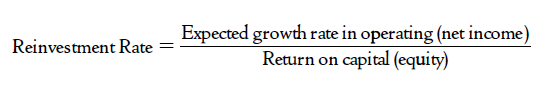

In [93]:
reinvestment_rate = (growth_rate / cash_flow_sheet['ROE'].iloc[0])
print("Reinvenstment rate: ", reinvestment_rate)

Reinvenstment rate:  0.5344418052256532


We assumed that the firm would be in stable growth after the fifth year and grow forever at the risk-free rate. As the growth declines after year five, the beta is adjusted towards one and the debt ratio is raised to the industry average to reflect the overall stability of the company. Then we proceed to use the stable growth cost of capital for the following formula (in the book example that number is 6.76%).The reinvestment rate in stable growth is changed to reflect the assumption that there will be no excess returns in stable growth (return on capital = cost of capital).
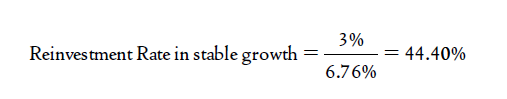

Where:

    1) 3% = Grow rate = Risk free rate
    2) 6.76% Stable growth cost of capital

In [94]:
reinvestment_rate_in_stable_growth = risk_free_rate/cost_of_capital_stable_growth
print(" Reinvenstment rate: ", reinvestment_rate
        ,"\n" , "Reinvestment_rate_in_stable_growth: ", reinvestment_rate_in_stable_growth)

 Reinvenstment rate:  0.5344418052256532 
 Reinvestment_rate_in_stable_growth:  0.016177826468743377


In [95]:
expected_FCF_op_income = pd.DataFrame()
expected_FCF_op_income['Year'] = cash_flow_sheet['Date'].dt.year
expected_FCF_op_income = expected_FCF_op_income.drop(['Year'], axis=1)
expected_FCF_op_income['Current_Net_Income'] = result['Net Income']
expected_FCF_op_income = expected_FCF_op_income.drop(expected_FCF_op_income.index[1:])
expected_FCF_op_income['1st_year'] = expected_FCF_op_income['Current_Net_Income']* (1+growth_rate)
expected_FCF_op_income['2nd_year'] = expected_FCF_op_income['1st_year'] * (1+growth_rate)

expected_FCF_op_income['3rd_year'] = expected_FCF_op_income['2nd_year'] * (1+growth_rate)
expected_FCF_op_income['4th_year'] = expected_FCF_op_income['3rd_year'] * (1+growth_rate)
expected_FCF_op_income['5th_year'] = expected_FCF_op_income['4th_year'] * (1+growth_rate)
expected_FCF_op_income['1st_year'] = expected_FCF_op_income['1st_year'] - (
    expected_FCF_op_income['1st_year'] * (1- retention_ratio))
expected_FCF_op_income['2nd_year'] = expected_FCF_op_income['2nd_year'] - (
    expected_FCF_op_income['2nd_year'] * (1- retention_ratio))
expected_FCF_op_income['3rd_year'] = expected_FCF_op_income['3rd_year'] - (
    expected_FCF_op_income['3rd_year'] * (1- retention_ratio))
expected_FCF_op_income['4th_year'] = expected_FCF_op_income['4th_year'] - (
    expected_FCF_op_income['4th_year'] * (1- retention_ratio))
expected_FCF_op_income['5th_year'] = expected_FCF_op_income['5th_year'] - (
    expected_FCF_op_income['5th_year'] * (1- retention_ratio))
expected_FCF_op_income = Format_Table(expected_FCF_op_income)

In [96]:
expected_FCF_op_income

,Current_Net_Income,1st_year,2nd_year,3rd_year,4th_year,5th_year
0,"6,315,000,000.0","4,414,315,617.5772","5,773,683,665.6551","7,551,662,807.7783","9,877,162,391.423","12,918,788,800.5347"


In [97]:
terminal_value_at_5th_year = ((expected_FCF_op_income['5th_year'].iloc[0]*(1+risk_free_rate)*(1-reinvestment_rate_in_stable_growth))/
                              (cost_of_capital_stable_growth - risk_free_rate))

formated_terminal_value = "${:,.2f}". format(terminal_value_at_5th_year)
print("Terminal_value_at_5th_year: ", formated_terminal_value)

Terminal_value_at_5th_year:  $14,722,742,604.05


In [98]:
discounted_terminal_value = pd.DataFrame()

discounted_terminal_value['1st_year'] = expected_FCF_op_income['1st_year']/(1+cost_of_capital)
discounted_terminal_value['2nd_year'] = expected_FCF_op_income['2nd_year']/(1+cost_of_capital)**2
discounted_terminal_value['3rd_year'] = expected_FCF_op_income['3rd_year']/(1+cost_of_capital)**3
discounted_terminal_value['4th_year'] = expected_FCF_op_income['4th_year']/(1+cost_of_capital)**4
discounted_terminal_value['5th_year'] = (expected_FCF_op_income['5th_year']+terminal_value_at_5th_year
                                        )/(1+cost_of_capital)**5
discounted_terminal_value['Final_Value'] = (discounted_terminal_value['1st_year'] +
                                            discounted_terminal_value['2nd_year'] +
                                            discounted_terminal_value['3rd_year'] +
                                            discounted_terminal_value['4th_year'] +
                                            discounted_terminal_value['5th_year'])
discounted_terminal_value

,1st_year,2nd_year,3rd_year,4th_year,5th_year,Final_Value
0,"4,203,661,662.452057","5,235,784,110.331609","6,521,322,944.437541","8,122,499,333.333642","21,646,314,454.17671","45,729,582,504.73155"


## Output

In [99]:
possible_target_share_price = discounted_terminal_value['Final_Value'].iloc[0]/ entreprise_value_sheet['Shares'].iloc[0]
"Target Share Price: ${:,.2f}". format(possible_target_share_price)
print("Shares Outstanding: {:,}". format(entreprise_value_sheet['Shares'].iloc[0]))
print("Target Share Price: ${:,.2f}". format(possible_target_share_price))
print("Current Share Price: ${:,.2f}". format(data['Close'].iloc[-1]))

Shares Outstanding: 272,327,008.0
Target Share Price: $167.92
Current Share Price: $351.16


# Graham number
The Graham number is a figure that measures a stock's fundamental value by taking into account the company's earnings per share and book value per share. The Graham number is the upper bound of the price range that a defensive investor should pay for the stock. According to the theory, any stock price below the Graham number is considered undervalued and thus worth investing in.
This number tells you the Max. ammount of money you should pay for a given stock at T time.

 The 22.5 is included in the calculation to account for Graham's belief that the price to earnings ratio should not be over 15 and the price to book ratio should not be over 1.5 (15 x 1.5 = 22.5).

In [100]:
graham_number = fcf_valuation[['Year', 'CFO', 'Wacc1', 'Firm_Value', 'Shares']].copy()
graham_number = pd.merge(graham_number, result[['Year', 'Total Stockholder Equity', 'Net Income']], on='Year', how='left')
graham_number['Graham_number'] = np.sqrt(22.5 * \
                                         (graham_number['Net Income']/ graham_number['Shares']) \
                                         * (graham_number['Total Stockholder Equity']/ graham_number['Shares']))
graham_number = Format_Table(graham_number)
graham_number

,Year,CFO,Wacc1,Firm_Value,Shares,Total Stockholder Equity,Net Income,Graham_number
0,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
1,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
2,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
3,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
4,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
5,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
6,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
7,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
8,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014
9,2021,"9,221,000,000.0",0.1082,"8,320,700,234.6147","272,327,008.0","10,959,000,000.0","6,315,000,000.0",144.9014


In [101]:
import sys
import importlib
importlib.reload(sys)
# importlib.reload(FinancialDataDef)
from FinancialDataDef import FinancialData

import os
import json
current_dir = os.path.abspath('')
peers_dir = os.path.join(current_dir, "Peers_By_Stock")
file_target = os.path.join(peers_dir, str(ticker+".json"))
file_target = open(file_target)
file = json.load(file_target)
peer_list = file
peer_list = list(dict.fromkeys(peer_list))
# peer_list = ['BA']
peer_list.append(ticker)

In [103]:
peers_class_dict = {}
peers_class_list = [FinancialData(peer, ticker, start_date, end_date) for peer in peer_list]
print(peer.ticker for peer in peers_class_list)

Starting with BA


C:\Users\Lenovo\Documents\Dev\equity_valuator\FinancialDataDef.py:220: RuntimeWarning:

invalid value encountered in log

C:\Users\Lenovo\Documents\Dev\equity_valuator\FinancialDataDef.py:262: RuntimeWarning:

invalid value encountered in log



BA finished
Starting with RTX
RTX finished
Starting with LMT
LMT finished
Starting with NOC
NOC finished
Starting with GD
GD finished
Starting with LHX
LHX finished
Starting with TDG
TDG finished
Starting with HEI
HEI finished
Starting with TDY
Statement Year is bigger than avg price year
2021
TDY finished
Starting with TXT
Statement Year is bigger than avg price year
2021
TXT finished
Starting with LMT
LMT finished
<generator object <genexpr> at 0x000001CBA5F94C00>


In [104]:
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.ticker as tick

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [105]:
import locale
import seaborn as sns
locale.setlocale(locale.LC_ALL, '')
import plotly.graph_objects as go
import plotly.express as px


def Get_Target_Peer_Metric(metric, snd_metric, target_table
                           , current_target_table, scale_factor, graph):
    
    if graph == "scatter":
        metric_table = pd.DataFrame()
        metric_table['Symbol'] = ticker
        metric_table["{}".format(metric)] = current_target_table["{}".format(metric)].iloc[0]
        metric_table["{}".format(snd_metric)] = current_target_table["{}".format(snd_metric)].iloc[0]
        for peer in peers_class_list:
            peer_dict = {'Symbol': peer.symbol, metric: getattr(peer,target_table)["{}".format(metric)].iloc[0],
                        snd_metric: getattr(peer,target_table)["{}".format(snd_metric)].iloc[0]}
            metric_table = metric_table.append(peer_dict, ignore_index=True)
        # Get Unique continents
        color_labels = metric_table['Symbol']

        # List of colors in the color palettes
        rgb_values = sns.color_palette("Set2", 10)

        # Map continents to the colors
        color_map = dict(zip(color_labels, rgb_values))

        # Finally use the mapped values

        plt.figure(figsize=(15, 8), dpi=80)
        plt.xlabel("{}".format(metric))
        plt.ylabel("{}".format(snd_metric))
        plt.scatter(metric_table["{}".format(metric)]
                    , metric_table["{}".format(snd_metric)]
                    , s=(metric_table["{}".format(metric)]/scale_factor)
                   , c=metric_table['Symbol'].map(color_map))
        xmin, xmax = plt.xlim()
        ymin, ymax = plt.ylim()
        plt.xlim(xmin + xmin * 0.1, xmax + xmax*0.1)
        plt.ylim(ymin + ymin * 0.1, ymax + ymax*0.1)


        for i, txt in enumerate(metric_table['Symbol'] ):
            plt.annotate("{}\n\n{}".format(txt
                         , locale.currency(metric_table["{}".format(metric)][i], grouping=True))
                         , (metric_table["{}".format(metric)][i], metric_table["{}".format(snd_metric)][i]))
        ax = plt.gca()
        ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
        metric_table = metric_table.drop_duplicates(subset =["Symbol"])

        return metric_table

    elif graph == "bars":


        metric_table = pd.DataFrame()
        metric_table['Symbol'] = ticker
        metric_table["{}".format(metric)] = current_target_table["{}".format(metric)].iloc[0]
        for peer in peers_class_list:
            peer_dict = {'Symbol': peer.symbol, metric: getattr(peer,target_table)["{}".format(metric)].iloc[0]}
            metric_table = metric_table.append(peer_dict, ignore_index=True)

        
#         ax = metric_table[['Symbol',"{}".format(metric)]].plot(kind='bar', title ="{}".format(metric), figsize=(15, 10), legend=True, fontsize=12)
#         ax.set_xlabel("Symbol", fontsize=12)
#         ax.set_ylabel("{}".format(metric), fontsize=12)
#         ax.set_xticklabels(metric_table['Symbol'])


#         plt.xlabel("{}".format(metric))
#         ay = plt.gca()
#         ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values));
#         for p in ax.patches:
#                 ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

        metric_table = metric_table.drop_duplicates(subset =["Symbol"])
        fig2 = px.bar(metric_table, x='Symbol', y="{}".format(metric), title='{}. Year {}'.format(metric
                                                                                                 ,current_target_table["Year"].iloc[0]))
        fig2.show()
        return metric_table
        
    
    if graph == 'lines':
        metric_table = pd.DataFrame()
        metric_table['Year'] = current_target_table['Year']
#         metric_table["{}".format(metric)] = current_target_table["{}".format(metric)]
        for peer in peers_class_list:
            metric_table["{}".format(peer.symbol)]= getattr(peer,target_table)["{}".format(metric)]
        fig = px.line(metric_table, x="Year",y=[i for i in peer_list], title="{}".format(metric))
        fig.show()
        return metric_table

,Symbol,Market Cap,Ev / Ebitda
0,BA,"116,844,860,000.0",118.92
1,RTX,"124,534,937,164.8",13.59
2,LMT,"92,811,767,596.48",11.6
3,NOC,"57,921,647,100.0",8.02
4,GD,"55,889,496,259.84",12.78
5,LHX,"40,866,280,220.0",13.18
6,TDG,"34,161,880,495.0",26.61
7,HEI,"7,506,474,848.0",15.87
8,TDY,0.0,3.97
9,TXT,0.0,2.51


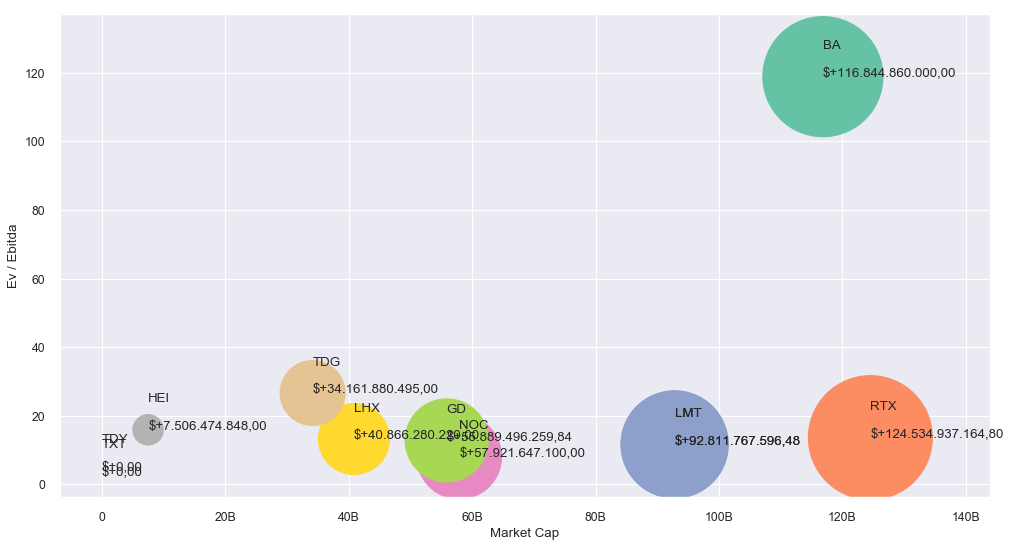

In [106]:
Get_Target_Peer_Metric('Market Cap', 'Ev / Ebitda', 'entreprise_value_sheet'
                       , entreprise_value_sheet,10000000, "scatter")

,Symbol,Debt,Ev / Ebitda
0,BA,"56,422,000,000.0",118.92
1,RTX,"31,250,000,000.0",13.59
2,LMT,"11,676,000,000.0",11.6
3,NOC,"12,783,000,000.0",8.02
4,GD,"11,495,000,000.0",12.78
5,LHX,"7,059,000,000.0",13.18
6,TDG,"19,829,000,000.0",26.61
7,HEI,"225,253,000.0",15.87
8,TDY,"4,100,700,000.0",3.97
9,TXT,"3,185,000,000.0",2.51


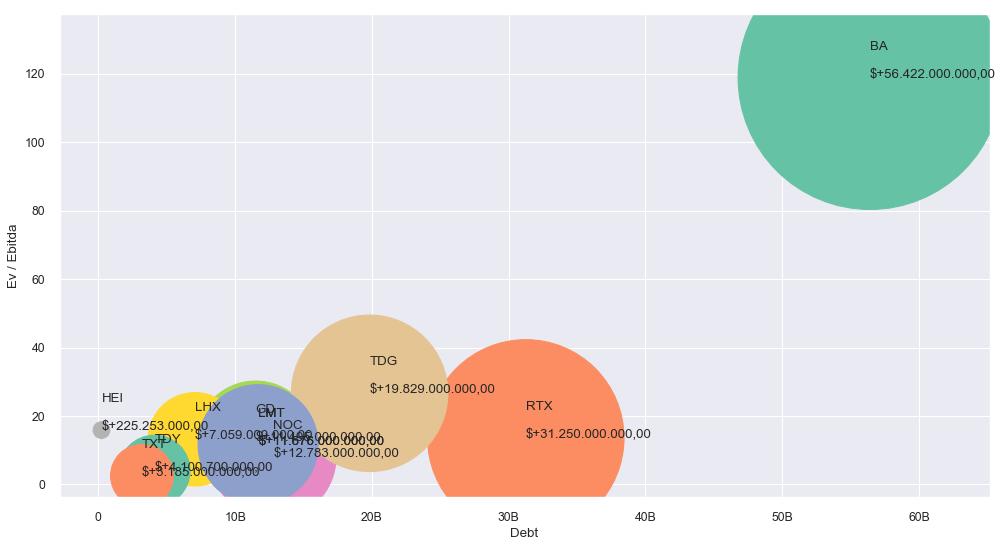

In [107]:
Get_Target_Peer_Metric('Debt', 'Ev / Ebitda', 'entreprise_value_sheet', entreprise_value_sheet, 1000000, "scatter")

In [108]:
Get_Target_Peer_Metric('Debt','null', 'entreprise_value_sheet', entreprise_value_sheet, 1, "bars")

,Symbol,Debt
0,BA,"56,422,000,000.0"
1,RTX,"31,250,000,000.0"
2,LMT,"11,676,000,000.0"
3,NOC,"12,783,000,000.0"
4,GD,"11,495,000,000.0"
5,LHX,"7,059,000,000.0"
6,TDG,"19,829,000,000.0"
7,HEI,"225,253,000.0"
8,TDY,"4,100,700,000.0"
9,TXT,"3,185,000,000.0"


In [109]:
Get_Target_Peer_Metric('Price_to_earnings','null', 'entreprise_value_sheet', entreprise_value_sheet, 1, "bars")

,Symbol,Price_to_earnings
0,BA,-27.81
1,RTX,32.23
2,LMT,14.7
3,NOC,8.27
4,GD,17.16
5,LHX,22.14
6,TDG,50.24
7,HEI,24.67
8,TDY,0.0
9,TXT,0.0


In [110]:
Get_Target_Peer_Metric('Debt','null', 'entreprise_value_sheet', entreprise_value_sheet, 1, "lines")

,Year,BA,RTX,LMT,NOC,GD,LHX,TDG,HEI,TDY,TXT
0,2021,"56,422,000,000.0","31,250,000,000.0","11,676,000,000.0","12,783,000,000.0","11,495,000,000.0","7,059,000,000.0","19,829,000,000.0","225,253,000.0","4,100,700,000.0","3,185,000,000.0"
1,2020,"61,780,000,000.0","31,512,000,000.0","12,169,000,000.0","15,003,000,000.0","12,998,000,000.0","7,059,000,000.0","19,987,000,000.0","730,264,000.0","781,800,000.0","3,707,000,000.0"
2,2019,"25,073,000,000.0","40,883,000,000.0","12,654,000,000.0","13,879,000,000.0","11,930,000,000.0","7,059,000,000.0","16,714,000,000.0","553,320,000.0","850,600,000.0","3,082,000,000.0"
3,2018,"11,191,000,000.0","43,996,000,000.0","13,504,000,000.0","14,400,000,000.0","11,567,000,000.0","7,059,000,000.0","12,578,433,000.0","531,611,000.0","747,500,000.0","3,066,000,000.0"
